# Background

## Some hypotheses on the movement maps

UTC 00:00 = EDT 19:00 --> People move from workplace to home between 7pm and 3am, but it is also worth exploring since during disasters there might be a surge in travellers during midnight time.

UTC 08:00 = EDT 03:00 --> People do not move much between 3am to 11am, ideally from workplace home. The importance of a node from the graph indicates the economic competatitiveness of the node city.

UTC 16:00 = EDT 11:00 --> People move most frequently between 11am and 7pm. The importance of a node from the graph indicates the residential competativeness of the node city.

## Facts
Please refer to the project proposal for the detailed disaster facts. North Carolina, South Carolina, Virginia are the 3 most affected states by Hurricane Florence. The 3 states are the foci of this case study. Evacuation details can be found from the link here:
https://www.businessinsider.com/know-your-zone-hurricane-florence-evacuations-carolinas-virginia-2018-9

## Economy in the 3 states

North Carolina includes the following metropolitan areas: Asheville, Burlington, Charlotte-Gastonia-Rock Hill (NC-SC), Durham-Chapel Hill, Fayetteville, Goldsboro, Greensboro-High Point, Greenville, Hickory-Lenoir-Morganton, Jacksonville, Myrtle Beach-Conway-North Myrtle Beach (includes Brunswick County, NC), Raleigh-Cary, Rocky Mount, Virginia Beach-Norfolk-Newport News (includes Northeastern NC and part of Outer Banks), Wilmington, and Winston-Salem

North Carlina most populated cities:

Rank|Name|County|Pop.
------ | ------ | ------| ------
1 | Charlotte | Mecklenburg | 842,051 
2|	Raleigh	|Wake|	458,880
3|	Greensboro|	Guilford|	287,027
4|	Durham	|Durham|	263,016
5|	Winston-Salem|	Forsyth|	244,605
6|	Fayetteville|	Cumberland|	204,759
7|	Cary|	Wake|	162,320
8|	Wilmington|	New Hanover|	117,525
9|	High Point|	Guilford|	111,223
10|	Greenville|	Pitt|	91,495

South Carlina most populated cities:

Rank|Name|County|Pop.
------ | ------ | ------| ------
1|Charleston|Charleston	|134,385
2|Columbia	|Richland	|134,309
3|	North Charleston	|Charleston	|108,304
4| Mount Pleasant|	Charleston|	81,317
5|	Rock Hill|	York|	72,937
6|	Greenville|	Greenville|	67,453
7|	Summerville|	Dorchester|	48,848
8|	Sumter|	Sumter|	40,816
9|	Goose Creek|	Berkeley|	40,633
10|	Hilton Head Island|	Beaufort	|40,512

Virginia most populated cities:

Rank|Name|County|Pop.
------ | ------ | ------| ------
1	|Virginia Beach|	Independent city|	452,602	
2	|Norfolk	|Independent city	|245,115
3	|Chesapeake	|Independent city	|237,940
4	|Arlington	|Arlington	|230,050
5	|Richmond	|Independent city	|223,170
6	|Newport News	|Independent city	|181,825
7	|Alexandria	|Independent city	|155,810
8	|Hampton	|Independent city	|135,410
9	|Roanoke	|Independent city	|99,660
10	|Portsmouth	|Independent city	|95,252

# Dataframe

## Load Data on Sept 10 11:00 - 19:00 EDT (Dataset named as UTC 00:00)

In [557]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy, deepcopy
import geocoder
import geopy.distance
from pprint import pprint
import folium
import igraph
sns.set()

In [2]:
def geo_location(df):
    extracted_lonlat=df['Geometry'][df['Geometry'].str.contains('POINT')].str.replace('(POINT )|\(|\)|,', '').str.split()
    df['Geometry'][df['Geometry'].str.contains('POINT')] = list(map(lambda x: x[0] + ', ' + x[1] + ', '+x[0] + ', ' + x[1], extracted_lonlat))
    split_lonlat = df['Geometry'].str.replace('(MULTILINESTRING )|\(|\)|,', '').str.split()
    location_features = ['Starting location lon', 'Starting location lat', 'Ending location lon', 'Ending location lat']
    for i in range(4):
        df[location_features[i]] = pd.Series(map(lambda x: x[i], split_lonlat)).astype('float')

## Add Geo-locations

The geo-locations are not precise. They are extracted from the arrow geometry, which is used more for a drawing purpose rather than a geological purpose.

In [3]:
df = pd.read_csv('Datasets/florence_admin_movement_sep_10_00.csv')
geo_location(df)
df.head()

Date Time  Ending Location Ending Region Name  Length(km)  \
0  2018-09-10 0000               39        Millville_2   52.920851   
1  2018-09-10 0000               16       Ventnor City    7.567495   
2  2018-09-10 0000               24       Ocean View_1   27.377756   
3  2018-09-10 0000             3031     Williamsburg_7   33.807910   
4  2018-09-10 0000             2911           Vinton_5   10.618549   

   Baseline: People Moving  Crisis: People Moving  Difference  Percent Change  \
0                      0.0                    3.0         NaN             NaN   
1                     75.0                   58.0       -17.0      -22.368421   
2                      7.6                    3.0         NaN             NaN   
3                     28.0                   23.0        -5.0      -17.241379   
4                     56.2                   52.0        -4.4       -7.665505   

   Starting Location Starting Region Name  Standard (Z) Score  \
0                  3           Brigantine            6.708204   
1                  7            Linwood_1           -1.170328   
2                 20           Cape May_1           -0.896974   
3               1202            Hampton_5           -0.725476   
4               3800            Roanoke_5           -0.578554   

                                            Geometry  Starting location lon  \
0  MULTILINESTRING ((-74.3994140599999980 39.4022...             -74.399414   
1  MULTILINESTRING ((-74.4902024699999998 39.3335...             -74.490202   
2  MULTILINESTRING ((-74.9267578099999980 38.9935...             -74.926758   
3  MULTILINESTRING ((-76.4094344399999983 37.0551...             -76.409434   
4  MULTILINESTRING ((-79.8516302000000024 37.2654...             -79.851630   

   Starting location lat  Ending location lon  Ending location lat  
0              39.402236           -75.014648            39.402236  
1              39.333513           -74.487305            39.334289  
2              38.993564           -74.750977            39.198197  
3              37.055169           -76.684570            37.265302  
4              37.265427           -79.848633            37.265302

## Fill NA

### Fill null values

There are many NA values in the datasets. Often times, 'Baseline: People Moving' and 'Crisis: People Moving' are NA at the same time; 'Difference' and 'Percentage Change' are NA at the same time. These 4 features are filled first.

In [4]:
idx = pd.isnull(df['Baseline: People Moving'])
df['Baseline: People Moving'][idx] = 100 * df[idx]['Difference']/df[idx]['Percent Change']
idx = pd.isnull(df['Crisis: People Moving'])
df['Crisis: People Moving'][idx] = df[idx]['Difference'] + df[idx]['Baseline: People Moving']

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
idx = pd.isnull(df['Difference'])
df['Difference'][idx] = df['Crisis: People Moving'][idx] - df['Baseline: People Moving'][idx]
idx = pd.isnull(df['Percent Change'])
df['Percent Change'][idx] = df['Difference'][idx] / df['Baseline: People Moving'][idx] *100

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Z score is calculated as:

$$Standard (Z) Score = \frac{Crisis: People Moving - Baseline: People Moving}{Standard Deviation of Baseline (Unknown)}$$

However, there are inconsistencies in the datasets. 

$$Crisis: People Moving - Baseline: People Moving \neq Difference$$

I found 'Crisis: People Moving' and 'Difference' are more reliable values because 0 exists extensively in 'Baseline: People Moving' and in a large number of cases it does not make sense. 'Baseline: People Moving' is recalculated as 'Crisis: People Moving' - 'Difference'. The 'Standard (Z) Score' are recalculated based on the median $\frac{standard deviation}{baseline}$ value from the rest of the samples.


/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16b35590>]],
      dtype=object)

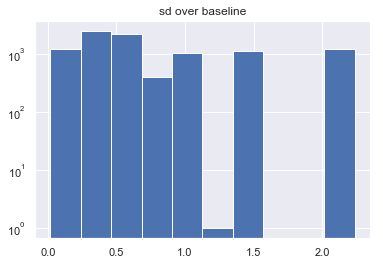

In [6]:
df_z_calc = df[(pd.isnull(df['Standard (Z) Score'])==False) & (df['Crisis: People Moving'] - df['Baseline: People Moving']==df['Difference']) & (df['Standard (Z) Score']!=0) &(df['Baseline: People Moving']>0)]
df_z_calc['sd over baseline'] = df_z_calc['Difference'] / df_z_calc['Standard (Z) Score'] / df_z_calc['Baseline: People Moving']
df_z_calc.hist('sd over baseline', log=True)

In [7]:
df_z_calc['sd over baseline'].describe()

count    9730.000000
mean        0.818589
std         0.652235
min         0.018890
25%         0.342327
50%         0.570513
75%         1.067078
max         2.236068
Name: sd over baseline, dtype: float64

In [8]:
sd_over_baseline = df_z_calc['sd over baseline'].median()

In [13]:
df['Baseline: People Moving'] = df['Crisis: People Moving'] - df['Difference']

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
idx = (pd.isnull(df['Standard (Z) Score'])|idx)&(df['Baseline: People Moving']!=0)
df['Standard (Z) Score'][idx] = df['Difference'][idx]/(sd_over_baseline * df['Baseline: People Moving'][idx])

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
pd.isnull(df).any()

Date Time                  False
Ending Location            False
Ending Region Name         False
Length(km)                 False
Baseline: People Moving    False
Crisis: People Moving      False
Difference                 False
Percent Change             False
Starting Location          False
Starting Region Name       False
Standard (Z) Score         False
Geometry                   False
Starting location lon      False
Starting location lat      False
Ending location lon        False
Ending location lat        False
dtype: bool

In [19]:
df.describe()

Ending Location    Length(km)  Baseline: People Moving  \
count     20337.000000  2.033700e+04             20337.000000   
mean       2657.867581  3.451303e+01               129.865747   
std        1679.527074  5.321482e+01              1546.966563   
min          -1.000000  8.023801e-12                 0.000000   
25%        1125.000000  1.093481e+01                 1.200000   
50%        2633.000000  2.140410e+01                 6.400000   
75%        4161.000000  3.582045e+01                22.000000   
max        5863.000000  9.015370e+02            155626.700000   

       Crisis: People Moving    Difference  Percent Change  Starting Location  \
count           20337.000000  20337.000000    2.033700e+04       20337.000000   
mean              128.698628     -1.167119             inf        2651.523479   
std              1450.036627    167.717840             NaN        1680.103049   
min                 3.000000 -22256.700000   -9.856597e+01          -1.000000   
25%                 4.000000     -3.000000   -1.549296e+01        1125.000000   
50%                 7.000000      1.200000    1.065574e+01        2623.000000   
75%                20.000000      3.000000    4.000000e+02        4174.000000   
max            133370.000000   3886.200000             inf        5863.000000   

       Standard (Z) Score  Starting location lon  Starting location lat  \
count        20337.000000           20337.000000           20337.000000   
mean             3.211394             -79.972214              36.444995   
std             28.187875               2.660835               2.075625   
min            -28.626924             -84.419722              31.914083   
25%             -0.314627             -82.309570              34.780606   
50%              0.209291             -79.938347              36.307276   
75%              1.897367             -77.390633              38.585065   
max           2640.796281             -74.399414              39.402236   

       Ending location lon  Ending location lat  
count         20337.000000         20337.000000  
mean            -79.972385            36.543877  
std               2.657221             2.073333  
min             -84.418945            31.914860  
25%             -82.309570            34.921963  
50%             -79.936523            36.421274  
75%             -77.388252            38.719797  
max             -74.399414            39.402236

### Fill '__' region names and '-1' locations

Some region names are missing. They are firstly found by searching for their closest named region. For unnamed regions within 5km to an known region, the name and code of the latter are assigned to the former.

In [20]:
def fill_unknown_regions(df, which, threshold=5): # which could fill in "Starting" or "Ending"
    if which == 'starting':
        which = 'Starting'
    elif which == 'ending':
        which = 'Ending'

    df.sort_values(by=[which + ' location lon', which + ' location lat'], inplace=True)
    for i in range(df.shape[0]):
        if '__' in df.iloc[i, ][which + ' Region Name']:
            lon = df.iloc[i, ][which + ' location lon']
            lat = df.iloc[i, ][which + ' location lat']
            if i+1 < df.shape[0]:
                diff_plus_1 = geopy.distance.vincenty((lat, lon), (df.iloc[i+1, ][which + ' location lat'], df.iloc[i+1, ][which + ' location lon'])).km
            else:
                diff_plus_1 = np.inf
            if i-1 >= 0:
                diff_minus_1 = geopy.distance.vincenty((lat, lon), (df.iloc[i-1, ][which + ' location lat'], df.iloc[i-1, ][which + ' location lon'])).km
            else:
                diff_minus_1 = np.inf
            if diff_plus_1 > diff_minus_1 and diff_minus_1 < threshold:
                if df[which + ' Region Name'].iloc[i-1]!='__':
                    df[which + ' Region Name'].iloc[i] = copy(df[which + ' Region Name'].iloc[i-1])
                    df[which + ' Location'].iloc[i] = copy(df[which + ' Location'].iloc[i-1])

            elif diff_plus_1 <= diff_minus_1 and diff_plus_1 < threshold:
                if df[which + ' Region Name'].iloc[i+1]!='__':
                    df[which + ' Region Name'].iloc[i] = copy(df[which + ' Region Name'].iloc[i+1])
                    df[which + ' Location'].iloc[i] = copy(df[which + ' Location'].iloc[i+1])

In [21]:
fill_unknown_regions(df, 'Starting')
fill_unknown_regions(df, 'Ending')

/anaconda2/envs/Py27/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Next, identify new regions with OpenCage.

In [22]:
locations = {}
for i in df[(df['Starting Region Name']=='__') | (df['Ending Region Name']=='__')].index:
    if df['Starting Region Name'].loc[i] == '__':
        geo_info = geocoder.opencage([df['Starting location lat'].loc[i], df['Starting location lon'].loc[i]], method='reverse', key='8793bad49e134015a1010a75f0bb4a52').json
        try:
            df['Starting Region Name'].loc[i] = geo_info['city'] + '_' + geo_info['county'] + '_' + geo_info['state']
        except KeyError:
            continue
        if df['Starting Region Name'].loc[i] in locations.keys():
            df['Starting Location'].loc[i] = locations.get(df['Starting Region Name'].loc[i])
        else:
            df['Starting Location'].loc[i] = max(df['Starting Location'].max(), df['Ending Location'].max()) + 1
            locations.update({df['Starting Region Name'].loc[i]: df['Starting Location'].loc[i]})
            
    if df['Ending Region Name'].loc[i] == '__':
        geo_info = geocoder.opencage([df['Ending location lat'].loc[i], df['Ending location lon'].loc[i]], method='reverse', key='8793bad49e134015a1010a75f0bb4a52').json
        try:
            df['Ending Region Name'].loc[i] = geo_info['city'] + '_' + geo_info['county'] + '_' + geo_info['state']
        except KeyError:
            continue
        if df['Ending Region Name'].loc[i] in locations.keys():
            df['Ending Location'].loc[i] = locations.get(df['Ending Region Name'].loc[i])
        else:
            df['Ending Location'].loc[i] = max(df['Starting Location'].max(), df['Ending Location'].max()) + 1
            locations.update({df['Ending Region Name'].loc[i]: df['Ending Location'].loc[i]})

Drop duplicates by only keeping the one with the most movements. Also drop the indistinguishable data.

In [28]:
df.sort_values(by=['Crisis: People Moving'], ascending=False, inplace=True)
df.drop_duplicates(subset=['Starting Region Name', 'Ending Region Name'], inplace=True)
df = df[(df['Starting Region Name']!='__')&(df['Ending Region Name']!='__')]

Finally, tackle the remaining '-1' location codes.

In [34]:
df_start = df[['Starting Location', 'Starting Region Name']].rename(columns={'Starting Location': 'location', 'Starting Region Name': 'region name'})
df_end = df[['Ending Location', 'Ending Region Name']].rename(columns={'Ending Location': 'location', 'Ending Region Name': 'region name'})
df_regions = pd.concat([df_start, df_end]).drop_duplicates()
del df_start
del df_end
to_be_assigned = df_regions[df_regions['location']==-1]['region name']
for region in to_be_assigned:
    df_regions['location'][df_regions['region name']==region] = df_regions['location'].max() + 1
df_minus_1 = df[(df['Starting Location']==-1)|(df['Ending Location']==-1)]
df = df[(df['Starting Location']!=-1)&(df['Ending Location']!=-1)]
df_minus_1 = df_minus_1.merge(df_regions, how='left', left_on='Starting Region Name', right_on='region name')
df_minus_1['Starting Location'] = copy(df_minus_1['location'])
df_minus_1.drop(columns=['location', 'region name'], inplace=True)
df_minus_1 = df_minus_1.merge(df_regions, how='left', left_on='Ending Region Name', right_on='region name')
df_minus_1['Ending Location'] = copy(df_minus_1['location'])
df_minus_1.drop(columns=['location', 'region name'], inplace=True)
df = df.append(df_minus_1)
del df_minus_1

In [43]:
df.describe()

Ending Location    Length(km)  Baseline: People Moving  \
count     20314.000000  2.031400e+04             20314.000000   
mean       2886.640297  3.449086e+01               129.886024   
std        1704.692104  5.308954e+01              1547.834947   
min           3.000000  8.023801e-12                 0.000000   
25%        1294.000000  1.093481e+01                 1.200000   
50%        2790.000000  2.140410e+01                 6.400000   
75%        4380.000000  3.581314e+01                22.000000   
max        5971.000000  9.015370e+02            155626.700000   

       Crisis: People Moving    Difference  Percent Change  Starting Location  \
count           20314.000000  20314.000000    2.031400e+04       20314.000000   
mean              128.762134     -1.123890             inf        2897.190411   
std              1450.853375    167.789056             NaN        1706.050859   
min                 3.000000 -22256.700000   -9.856597e+01           3.000000   
25%                 4.000000     -3.000000   -1.538462e+01        1305.000000   
50%                 7.000000      1.200000    1.111111e+01        2781.000000   
75%                20.000000      3.000000    4.000000e+02        4407.000000   
max            133370.000000   3886.200000             inf        5966.000000   

       Standard (Z) Score  Starting location lon  Starting location lat  \
count        20314.000000           20314.000000           20314.000000   
mean             3.200783             -79.975905              36.444418   
std             28.127861               2.659216               2.075545   
min            -28.626924             -84.419722              31.914083   
25%             -0.313907             -82.309570              34.780606   
50%              0.211023             -79.939027              36.299817   
75%              1.908552             -77.390683              38.584941   
max           2640.796281             -74.399414              39.402236   

       Ending location lon  Ending location lat  
count         20314.000000         20314.000000  
mean            -79.976040            36.543301  
std               2.655638             2.073259  
min             -84.418945            31.914860  
25%             -82.309570            34.921963  
50%             -79.936523            36.421274  
75%             -77.416100            38.719797  
max             -74.399414            39.402236

In [44]:
df.drop(index=4546, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17ccc890>]],
      dtype=object)

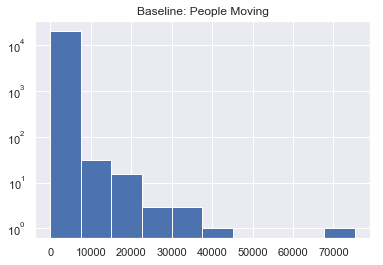

In [46]:
df.hist('Baseline: People Moving', log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a181ca090>]],
      dtype=object)

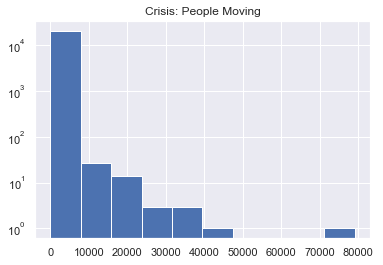

In [47]:
df.hist('Crisis: People Moving', log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1827dc50>]],
      dtype=object)

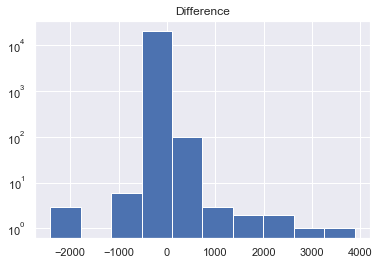

In [48]:
df.hist('Difference', log=True)

In [543]:
df.to_csv('cleansed_data/Sept_10_00.csv')

# Baseline DiGraph

In [558]:
def create_edgelist(df, when):
    if when.lower()=='baseline':
        return list(zip(df['Starting Region Name'], df['Ending Region Name'], df['Baseline: People Moving']))
    elif when.lower()=='crisis':
        return list(zip(df['Starting Region Name'], df['Ending Region Name'], df['Crisis: People Moving']))
    else:
        raise ValueError('Please choose one between "baseline" and "crisis".')

In [502]:
edgelist = create_edgelist(df, 'Baseline')

In [504]:
def create_graph(edgelist, self_edges=True, zero_weight_edges=False, directed=True, reverse=False):
    G = igraph.Graph(directed=directed)
    weight = []
    el = []
    vx = set()
    for edge in edgelist:
        vx.add(edge[0])
        vx.add(edge[1])
        if zero_weight_edges:
            if self_edges:
                if reverse:
                    el.append((edge[1], edge[0]))
                else:
                    el.append((edge[0], edge[1]))
                weight.append(edge[2])
            elif edge[0]!=edge[1]:
                if reverse:
                    el.append((edge[1], edge[0]))
                else:
                    el.append((edge[0], edge[1]))
                weight.append(edge[2])
        elif edge[2]!=0:
            if self_edges:
                if reverse:
                    el.append((edge[1], edge[0]))
                else:
                    el.append((edge[0], edge[1]))
                weight.append(edge[2])
            elif edge[0]!=edge[1]:
                if reverse:
                    el.append((edge[1], edge[0]))
                else:
                    el.append((edge[0], edge[1]))
                weight.append(edge[2])
    G.add_vertices(list(vx))
    G.add_edges(el)
    G.es['weight'] = weight
    return G

## Basic Statistics

In [540]:
def basic_stats(edgelist):
    G = create_graph(edgelist, zero_weight_edges=False)
    G_no_self = create_graph(edgelist, zero_weight_edges=False, self_edges=False)
    print 'number of nodes: %d' % G.vcount()
    print 'number of weighted edges: %d' % G.ecount()
    print 'total FB users: %d' % np.sum(G.es['weight'])
    print 'total FB users travelling between cities: %d' % np.sum(G_no_self.es['weight'])

In [541]:
basic_stats(edgelist)

number of nodes: 2899
number of weighted edges: 16479
total FB users: 2482878
total FB users travelling between cities: 429429


## pagerank, in-degree, out-degree, closeness, betweenness, cluster coefficient

In [123]:
def df_lonlat(df):
    df_start = df[['Starting Region Name', 'Starting location lon', 'Starting location lat']].rename(columns={'Starting Region Name': 'region name', 'Starting location lon': 'lon', 'Starting location lat':'lat'})
    df_end = df[['Ending Region Name', 'Ending location lon', 'Ending location lat']].rename(columns={'Ending Region Name': 'region name', 'Ending location lon': 'lon', 'Ending location lat': 'lat'})
    df_regions = pd.concat([df_start, df_end]).groupby('region name').mean().reset_index()
    return df_regions

In [537]:
#return pagerank, in-degree, out-degree, self-edge weight, closeness, betweenness, cluster coefficient.
# 'edgelist' overwrites 'when'.

def calc_params(df, when='crisis', edgelist=None, reverse=False): 
    df_regions = df_lonlat(df)
    if edgelist is None:
        edgelist = create_edgelist(df, when)
    G_no_self = create_graph(edgelist, reverse=reverse, self_edges=False)
    G = create_graph(edgelist, reverse=reverse, self_edges=True)
    G_no_self_und = create_graph(edgelist, reverse=reverse, self_edges=False, directed=False)
    prs = G_no_self.pagerank(weights='weight')
    prs_incl_self = G.pagerank(weights='weight')
    indeg = G.strength(mode=2, loops=False, weights='weight')
    indeg_incl_self = G.strength(mode=2, loops=True, weights='weight')
    outdeg = G.strength(mode=1, loops=False, weights='weight')
    outdeg_incl_self = G.strength(mode=1, loops=True, weights='weight')
    totdeg = np.array(indeg) + np.array(outdeg)
    totdeg_incl_self = np.array(indeg_incl_self) + np.array(outdeg_incl_self)
    cls = G_no_self.closeness(weights='weight')
    btw = G_no_self.betweenness(weights='weight')
    weighted_clust_coef = G_no_self_und.transitivity_local_undirected(mode="zero", weights='weight')
    clust_coef = G_no_self_und.transitivity_local_undirected(mode="zero")
    df_pr = pd.DataFrame(data={'region name':G.vs['name'], 'pagerank':prs, 'pagerank_incl_loops': prs_incl_self,
                              'in_degree': indeg, 'in_degree_incl_loops': indeg_incl_self, 'out_degree': outdeg,
                              'out_degree_incl_loops': outdeg_incl_self, 'total_degree': totdeg,
                              'total_degree_incl_loops': totdeg_incl_self, 'closeness': cls, 'betweenness': btw,
                              'weighted_cluster_coef': np.array(weighted_clust_coef)/2.0, 
                               'cluster_coef': clust_coef})
    df_pr = df_pr.merge(df_regions, how='left', on='region name')
    return df_pr

In [538]:
df_pr = calc_params(df, edgelist=edgelist)

In [513]:
df_pr.head()

betweenness  closeness  cluster_coef  in_degree  in_degree_incl_loops  \
0   7919.500000   0.003779      1.375000        3.6                   3.6   
1     56.500000   0.003794      1.388249       39.2                  39.2   
2  67197.166667   0.003807      0.722335      849.8                 849.8   
3      0.000000   0.003784      0.740359      601.0                3680.8   
4   4702.000000   0.003802      0.864979       78.8                 613.6   

   out_degree  out_degree_incl_loops  pagerank  pagerank_incl_loops  \
0         1.2                    1.2  0.000079             0.000068   
1         4.2                    4.2  0.000123             0.000086   
2      1136.2                 1136.2  0.000892             0.000166   
3       533.6                 3613.4  0.000543             0.000418   
4        31.8                  566.6  0.000191             0.000640   

     region name  total_degree  total_degree_incl_loops        lon        lat  
0      Catlett_1           4.8                      4.8 -77.672889  38.634621  
1  Bryans Road_1          43.4                     43.4 -77.114580  38.651104  
2       Garner_2        1986.0                   1986.0 -78.613054  35.621280  
3       Waxhaw_2        1134.6                   7294.2 -80.783561  34.973161  
4      Lothian_1         110.6                   1180.2 -76.657096  38.776565

In [544]:
df_pr.sort_values(by='pagerank', ascending=False).head(100)

betweenness  closeness  cluster_coef  in_degree  in_degree_incl_loops  \
180   3.007940e+06   0.003825      0.027213     6387.4               81635.2   
827   2.991570e+05   0.003810      0.049265     4262.0               37057.6   
643   3.690643e+05   0.003807      0.045103     1105.8               23167.4   
1439  3.849587e+05   0.003790      0.047704     1775.4               34085.6   
395   1.289339e+06   0.003821      0.108773     6964.0               45935.4   
815   4.484000e+03   0.003811      0.160240     7915.0               37906.8   
40    1.751222e+05   0.003808      0.069199     2111.4               23703.0   
408   2.055885e+05   0.003811      0.080343     7033.2                7033.2   
1346  2.317982e+05   0.003811      0.052924     1836.6               27594.6   
715   5.176167e+03   0.003780      0.147719     3803.2               24388.2   
2569  4.472000e+03   0.003798      0.114754     1931.2               19459.0   
1593  1.528050e+04   0.003800      0.074390     1521.8               19077.0   
428   1.332905e+05   0.003805      0.098230     3321.6               19074.4   
2815  3.341798e+05   0.003792      0.071644     2227.0               26967.8   
1538  2.210406e+05   0.003813      0.059426     1678.8               18816.6   
840   3.487667e+03   0.003791      0.144568     7139.2               29376.6   
652   1.993274e+05   0.003797      0.075070      826.6                8812.6   
1760  5.647225e+05   0.003814      0.069458     1126.8               13377.6   
2670  1.112457e+05   0.003775      0.056899      798.8                9149.4   
2572  1.565518e+05   0.003786      0.035631      468.8               10419.6   
1139  3.999287e+05   0.003806      0.051579      924.0               11424.2   
2763  6.267702e+04   0.003803      0.118559     2457.2               13715.4   
923   1.007052e+05   0.003794      0.040706      373.2                 373.2   
1823  4.505246e+05   0.003794      0.047475      515.4               10594.6   
1928  8.900833e+03   0.003776      0.081081      431.2                3881.6   
1032  1.604856e+05   0.003803      0.077441      865.8                6344.4   
2207  1.602757e+05   0.003810      0.082837     2063.0               10922.4   
1033  3.922287e+05   0.003809      0.079216      880.8                 880.8   
2049  8.045510e+04   0.003819      0.082583      254.6                4688.8   
2249  4.521863e+04   0.003800      0.079631     1806.0               21974.2   
...            ...        ...           ...        ...                   ...   
1143  1.181600e+04   0.003793      0.142248     1078.2                7536.2   
22    4.059017e+04   0.003810      0.058065       91.6                1355.8   
1420  9.275052e+04   0.003814      0.150075     1538.8                7881.6   
2175  2.701750e+04   0.003808      0.148081     1987.8               12775.4   
2365  1.465323e+05   0.003779      0.079545      405.0                3423.0   
2777  2.908000e+04   0.003800      0.152582     1833.6                1833.6   
2189  6.123190e+04   0.003746      0.096825      482.4                2904.0   
54    9.323215e+04   0.003805      0.068831      340.2                4139.2   
1393  1.043020e+05   0.003818      0.083333      451.6                3158.0   
1728  5.953500e+03   0.003755      0.161905      114.4                 569.6   
2181  2.864742e+04   0.003804      0.193065     2702.4                2702.4   
1719  4.291333e+03   0.003775      0.143687     1192.8                8984.6   
344   8.549866e+04   0.003819      0.066667      124.6                1583.2   
1521  1.350752e+05   0.003791      0.065338      230.0                4800.4   
2547  7.150037e+04   0.003788      0.171204     1541.2               12254.8   
1031  1.166489e+05   0.003788      0.126560      673.2                 673.2   
1974  1.618936e+05   0.003818      0.156448      914.2                3887.8   
2689  3.563300e+04   0.003774      0.082504      320.2                2793.4   
1419  2

In [ ]:
df_regions = df_pr[['region name', 'lon', 'lat']]
for param in df_pr.columns.values:
    if 

## Draw Node Degree Distribution (excluding self-edges)

In [110]:
G_no_self = nx.DiGraph()
#edgelist = list(zip(df['Starting Location'], df['Ending Location'], df['Baseline: People Moving']))
for edge in edgelist:
    if edge[2]!=0 and edge[0]!=edge[1]:
        G_no_self.add_weighted_edges_from([edge])

In [111]:
def draw_deg_dist(edgelist):
    G = nx.DiGraph()
    for edge in edgelist:
        if edge[2]!=0 and edge[0]!=edge[1]:
            G.add_weighted_edges_from([edge])
    #total
    deg_dict = {}
    for node, deg in G.degree(weight='weight'):
        deg_dict.update({node:deg})
    plt.figure(figsize=(10,7))
    sns.distplot(np.log(1 + np.array(deg_dict.values())), kde=True, rug=True, hist_kws={'alpha':0.5}, label='total')
    #in
    in_deg_dict = {}
    for node, deg in G.in_degree(weight='weight'):
        in_deg_dict.update({node:deg})
    sns.distplot(np.log(1 + np.array(in_deg_dict.values())), kde=True, rug=True, hist_kws={'alpha':0.5}, label='in')

    #out
    out_deg_dict = {}
    for node, deg in G.out_degree(weight='weight'):
        out_deg_dict.update({node:deg})
    sns.distplot(np.log(1 + np.array(out_deg_dict.values())), kde=True, rug=True, hist_kws={'alpha':0.5}, label='out')
    plt.xlabel('log(1 + Degree)')
    plt.ylabel('proportion')
    plt.legend()

/anaconda2/envs/Py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


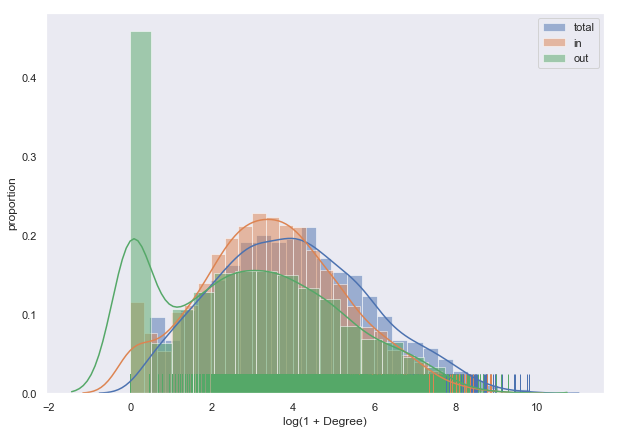

In [112]:
draw_deg_dist(edgelist)

In [559]:
from collections import defaultdict
from collections import OrderedDict

def draw_deg_count(edgelist):
    G = nx.DiGraph()
    for edge in edgelist:
        if edge[2]!=0 and edge[0]!=edge[1]:
            G.add_weighted_edges_from([edge])
    #total
    deg_dict = defaultdict(int)
    for node, deg in G.degree(weight='weight'):
        deg_dict[deg] += 1
    deg = list(deg_dict.keys())
    count = list(map(lambda x: deg_dict.get(x), deg))
    p_tot = np.polyfit(np.log(np.array(deg)+1), np.log(count), 1)
    plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
    plt.subplot(131)
    plt.scatter(np.log(deg), np.log(count))
    plt.xlabel('log(degree)')
    plt.ylabel('log(count)')
    plt.title('total degree')
    
    #in
    deg_dict = defaultdict(int)
    for node, deg in G.in_degree(weight='weight'):
        deg_dict[deg] += 1
    deg = list(deg_dict.keys())
    count = list(map(lambda x: deg_dict.get(x), deg))
    p_in = np.polyfit(np.log(np.array(deg)+1), np.log(count), 1)
    plt.subplot(132)
    plt.scatter(np.log(deg), np.log(count))
    plt.title('in degree')
    
    #out
    deg_dict = defaultdict(int)
    for node, deg in G.out_degree(weight='weight'):
        deg_dict[deg] += 1
    deg = list(deg_dict.keys())
    count = list(map(lambda x: deg_dict.get(x), deg))
    p_out = np.polyfit(np.log(np.array(deg)+1), np.log(count), 1)
    plt.subplot(133)
    plt.scatter(np.log(deg), np.log(count))
    plt.title('out degree')
    
    plt.show()
    print 'total degree: slope={}, intercept={}.'.format(p_tot[0], p_tot[1])
    print 'in degree: slope={}, intercept={}.'.format(p_in[0], p_in[1])
    print 'out degree: slope={}, intercept={}.'.format(p_out[0], p_out[1])

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


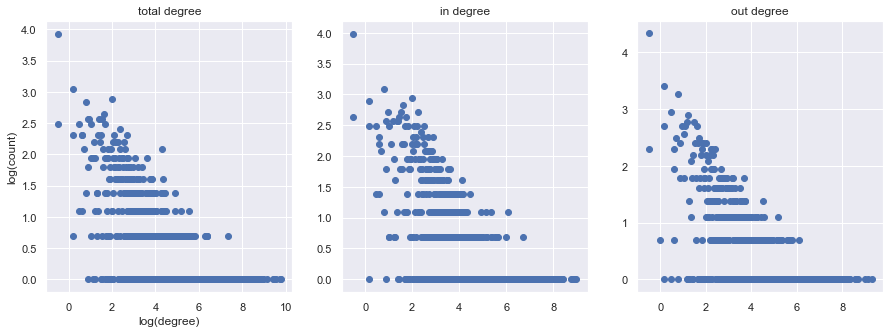

total degree: slope=-0.205737658898, intercept=1.31870395054.
in degree: slope=-0.273784430263, intercept=1.61588345365.
out degree: slope=-0.224546391679, intercept=1.34382530878.


In [560]:
df = pd.read_csv('cleansed_data/Sept_10_00.csv')
edgelist=create_edgelist(df, 'Baseline')
draw_deg_count(edgelist)

## Community Detection

In [308]:
G_no_self = create_graph(edgelist, self_edges=False)

In [326]:
communities = G_no_self.community_label_propagation(weights='weight')

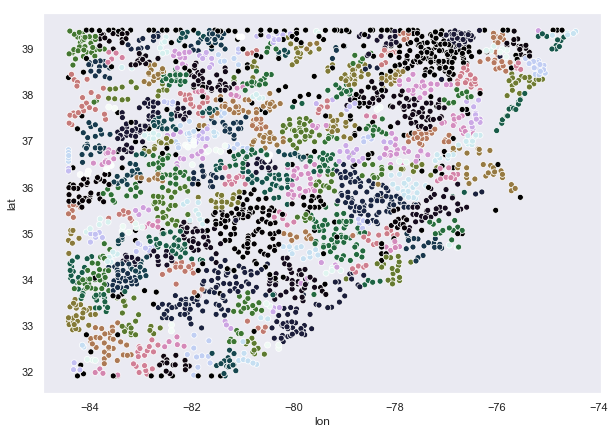

In [547]:
sgs = communities.subgraphs()
clust = [-1]*df_pr.shape[0]
for k in range(df_pr.shape[0]):
    for i in range(len(sgs)):
        if df_pr['region name'].iloc[k] in sgs[i].vs['name']:
            clust[k] = i
df_pr['community'] = clust
plt.figure(figsize=(10, 7))
sns.set_style('dark')
sns.scatterplot(x='lon', y='lat', hue='community', palette = 'cubehelix', data=df_pr, legend=False)

In [545]:
def draw_communities(df_regions, threshold=10, popup=True): # df_regions contains lon, lat, region name, community.
    df_community_size = df_regions['community'].value_counts().reset_index()
    df_community_size = df_community_size[(df_community_size['community'] >=threshold) &(df_community_size['index']!=-1)]
    from matplotlib import colors as mcolors
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    picked = np.random.choice(colors.keys(), df_community_size.shape[0], replace=False)
    colors_dict = {df_community_size['index'].iloc[i]:picked[i] for i in range(df_community_size.shape[0])}
    
    m = folium.Map(location=[35.7596, -79.0193], zoom_start=6)
    names = df_regions['region name'].str.replace('_.+County_.+', '').str.replace('[^a-zA-Z]', '')
    if popup:
        for i in range(df_regions.shape[0]):
            if df_regions['community'].iloc[i] in colors_dict.keys():
                lat = df_regions['lat'].iloc[i]
                lon = df_regions['lon'].iloc[i]
                c = colors_dict[df_regions['community'].iloc[i]]
                folium.Circle(
                    radius=200,
                    location=[lat, lon],
                    #tooltip = names.iloc[i],
                    popup = folium.Popup(names.iloc[i],parse_html=True),
                    color=c
                ).add_to(m)
    else:
        for i in range(df_regions.shape[0]):
            if df_regions['community'].iloc[i] in colors_dict.keys():
                lat = df_regions['lat'].iloc[i]
                lon = df_regions['lon'].iloc[i]
                c = colors_dict[df_regions['community'].iloc[i]]
                folium.Circle(
                    radius=200,
                    location=[lat, lon],
                    color=c
                ).add_to(m)
    return m

Visualize communities using Folium interactive map

In [548]:
m = draw_communities(df_pr, threshold=20)

In [549]:
m

In [550]:
m.save("baseline_time_00_size_20.html")

In [553]:
m = draw_communities(df_pr, threshold=10, popup=False)
m

In [554]:
m.save("baseline_time_00_size_10.html")

In [556]:
df_pr.to_csv('cleansed_data/baseline_00.csv')

# Crisis DiGraph

In [217]:
edgelist_crisis = list(zip(df['Starting Region Name'], df['Ending Region Name'], df['Crisis: People Moving']))
G_crisis = create_graph(edgelist_crisis)

In [218]:
basic_stats(G_crisis, 'Crisis')

number of nodes: 2899
number of weighted edges: 20313
total FB users: 2482304
total FB users travelling between cities: 419583


     log(PR)      region name        lon        lat  community
0  -5.416576      Baltimore_2 -76.829516  39.034119         11
1  -5.548473         Athens_3 -83.419232  33.948815         16
2  -5.583431   Fayetteville_5 -79.015504  34.941318         17
3  -5.629598     Greenville_7 -77.360838  35.500142         17
4  -5.637797      Knoxville_4 -83.979415  35.875629         19
5  -5.668549        Raleigh_3 -78.643845  35.697405         17
6  -5.749873      Charlotte_4 -80.886725  34.945569         37
7  -5.780042        Augusta_3 -82.026001  33.358464         25
8  -5.800428  Silver Spring_1 -77.084930  38.963142         11
9  -5.814963      Arlington_1 -77.283639  38.567293         11
10 -5.866857       Culpeper_1 -77.991748  38.435153          0
11 -5.886640    Spartanburg_2 -81.968496  34.883543         20
12 -5.926929      Pikeville_5 -82.540470  37.430722         22
13 -5.936500  Winston Salem_1 -80.255830  35.992246         14
14 -5.945616     Greensboro_1 -79.711127  35.928655    

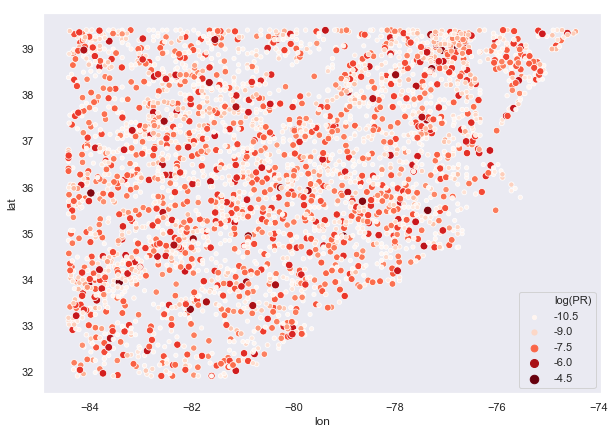

In [219]:
df_pr_c = calc_PR(G_crisis, df_regions)

     log(PR)        region name        lon        lat  community
0  -4.444919        Charlotte_4 -80.886725  34.945569         37
1  -4.997156  Charlottesville_3 -78.439707  37.920006         18
2  -5.098225       Charleston_6 -81.652820  38.268187         22
3  -5.113358        Knoxville_4 -83.979415  35.875629         19
4  -5.197619        Baltimore_2 -76.829516  39.034119         11
5  -5.218315           Hazard_2 -83.166623  37.231631         22
6  -5.239265        Parkersburg -81.543022  39.199751         22
7  -5.265985       Greensboro_1 -79.711127  35.928655         14
8  -5.267825       Greenville_7 -77.360838  35.500142         17
9  -5.296951     Fayetteville_5 -79.015504  34.941318         17
10 -5.321489       Wilmington_2 -77.954341  34.193377         17
11 -5.359364        Pikeville_5 -82.540470  37.430722         22
12 -5.363391            Beckley -81.150864  37.663257         22
13 -5.387155       Cincinnati_3 -84.117144  38.971289         21
14 -5.398220           At

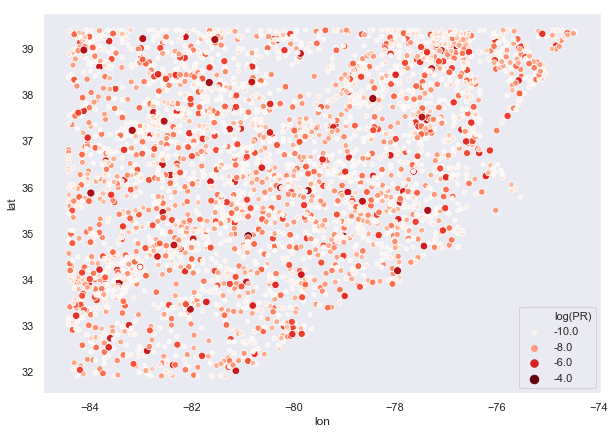

In [221]:
G_crisis_rev = create_graph(edgelist_crisis, reverse=True)
df_pr_c_rev = calc_PR(G_crisis_rev, df_regions)

In [63]:
nx.write_graphml(G,'so.graphml')

In [197]:
G_z = nx.DiGraph()
edgelist = list(zip(df['Starting Region Name'], df['Ending Region Name'], df['Standard (Z) Score']))
for edge in edgelist:
    if edge[2]!= None:
        G_z.add_weighted_edges_from([edge])

In [222]:
G_no_self = nx.DiGraph()
#edgelist = list(zip(df['Starting Location'], df['Ending Location'], df['Baseline: People Moving']))
for edge in edgelist:
    if edge[2]!=0 and edge[0]!=edge[1]:
        G_no_self.add_weighted_edges_from([edge])

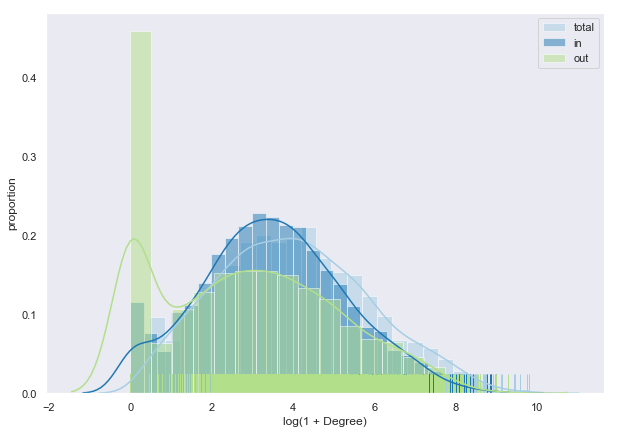

In [223]:
draw_deg_dist(G_no_self)

/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/anaconda2/envs/Py27/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


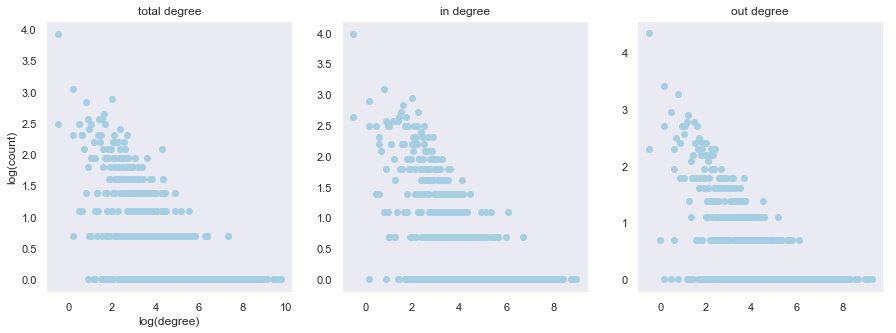

In [224]:
draw_deg_count(G_no_self)

# Upcoming Plan

1. Better (potentially interactive) visualization on map
2. Time Evolution of graph
3. Track evacuated counties (subgraphs) and selected cities (nodes)
4. Define anomalies: Z scores? L-1 norm of histogram? Monte Carlo? etc.

In [ ]:
# agent-based model Anylogic.
# e.g. remove Raleigh to see changes in movement.

Google API to track movement along real world road network.

PageRank good or not? Different options: deg centraities?

Resilience:
1. how to measure regional movement
2. can time of movement be related to evacuation order
3. storm arrival?
4. track power outage? road congestion?
5. link people and infrastructure.